<a href="https://colab.research.google.com/github/luanakwon/GreatBarrierReef/blob/main/GBR_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

In [1]:
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 3.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=3f5dcf3d2223b567c0653406dcd30ead79f58e9061a48d368dbb19490c9d38c1
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
!kaggle competitions download -c tensorflow-great-barrier-reef

100% 14.2G/14.2G [01:39<00:00, 200MB/s]
100% 14.2G/14.2G [01:39<00:00, 153MB/s]


In [4]:
!unzip -q /content/tensorflow-great-barrier-reef.zip 

# crop and save detected cots

In [5]:
# get train.csv
import pandas as pd

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]
...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[]
23497,2,29859,10756,2984,2-10756,[]
23498,2,29859,10757,2985,2-10757,[]
23499,2,29859,10758,2986,2-10758,[]


# bbox size vs RGB ratio

In [102]:
import numpy as np
# image shape : (H,W,C)
# image color : BGR
def getCPI_Info(img):
  height, width = img.shape[:2]
  mean_B,mean_G,mean_R = np.mean(img,axis=(0,1))
  return [height, width, mean_B, mean_G, mean_R]

In [103]:
import os
import cv2
from google.colab.patches import cv2_imshow

# make new dir for cropped image
os.makedirs('/content/cropped_images',exist_ok=True)

# cropped image info list
cpi_info = []

# crop and analyze each bbox
df = df_train[df_train['annotations'] != '[]']
df = df.reset_index()
for idx, row in df.iterrows():
  print(f"\r/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg",end='\t\t\t')
  frame = cv2.imread(f"/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg")
  bboxes = eval(row['annotations'])
  for bbox in bboxes:
    x,y,w,h = bbox.values()
    cots = frame[y:y+h,x:x+w]
    cpi_info.append(getCPI_Info(cots))
    if cpi_info[-1][2]+cpi_info[-1][3]+cpi_info[-1][4] == 0:
      cv2.imwrite(f"/content/cropped_images/{row['image_id']}.jpg",cots)

cpi_info = np.array(cpi_info)
cpi_area = cpi_info[:,0]*cpi_info[:,1]

/content/train_images/video_2/10632.jpg			

In [104]:
cpi_sqrt_area = np.sqrt(cpi_area)
bgrs = np.zeros((230,4))
for a, x in zip(cpi_sqrt_area,cpi_info):
  a = int(a)
  bgrs[a,0] += 1
  bgrs[a,1] += x[2]
  bgrs[a,2] += x[3]
  bgrs[a,3] += x[4]

  print(f'\r{int(a)}, {bgrs[a]}',end='\t\t')

# prevent zero division
bgrs[:,0] += (bgrs[:,0] == 0)
# mean value of colors
bgrs[:,1] /= bgrs[:,0]
bgrs[:,2] /= bgrs[:,0]
bgrs[:,3] /= bgrs[:,0]
# re-use first column as idx
bgrs[:,0] = np.arange(230)
# drop rows with no image
i = 0
for row in bgrs:
  if np.sum(row[1:]) != 0:
    bgrs[i] = row.copy()
    i += 1
bgrs = bgrs[:i]
print(f'dropped {230-i} rows')

41, [  308.         54697.03529964 48918.86650063 13262.47355349]		dropped 109 rows


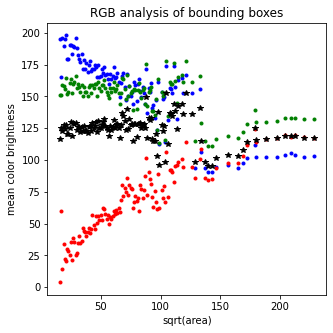

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.title('RGB analysis of bounding boxes')
plt.xlabel('sqrt(area)')
plt.ylabel('mean color brightness')
plt.plot(bgrs[:,0],bgrs[:,1],'b.',label='blue')
plt.plot(bgrs[:,0],bgrs[:,2],'g.',label='green')
plt.plot(bgrs[:,0],bgrs[:,3],'r.',label='red')
plt.plot(bgrs[:,0],np.sum(bgrs[:,1:],axis=1)/3,'k*',label='avg_RGB')


plt.show()

# Mean of all image with bbox

/content/train_images/video_2/10632.jpg			

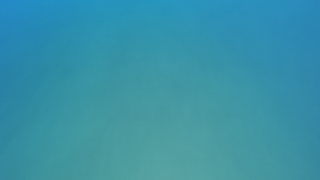


/content/train_images/video_2/10759.jpg			

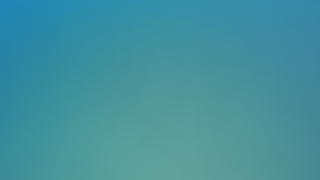

True

In [106]:
import cv2
from google.colab.patches import cv2_imshow

# overlap images with bbox only
df = df_train[df_train['annotations'] != '[]']
df = df.reset_index()
num_images = len(df)
canvas = np.zeros((720,1280,3))
for idx, row in df.iterrows():
  print(f"\r/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg",end='\t\t\t')
  frame = cv2.imread(f"/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg")
  canvas += (frame.astype(np.float64))/num_images

cv2_imshow(cv2.resize(canvas.astype(np.uint8),(320,180)))
cv2.imwrite('/content/ambient_color_only_bboxed.jpg',canvas.astype(np.uint8))

print('\n'+'='*100)

# also overlap images without bbox
df = df_train[df_train['annotations'] == '[]']
df = df.reset_index()
num_images_all = len(df_train)
canvas *= (num_images)/num_images_all
for idx, row in df.iterrows():
  print(f"\r/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg",end='\t\t\t')
  frame = cv2.imread(f"/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg")
  canvas += (frame.astype(np.float64))/num_images_all

cv2_imshow(cv2.resize(canvas.astype(np.uint8),(320,180)))
cv2.imwrite('/content/ambient_color_all.jpg',canvas.astype(np.uint8))


# removing ambient color from image
---

In [107]:
import cv2

def balance_ambient(src):
  ambient = cv2.GaussianBlur(src,(181,91),30)
  balanced = (src.astype(np.float32)-(ambient*0.5))
  balanced = balanced*(balanced > 0)*(255/np.max(balanced))
  return balanced.astype(np.uint8)

[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]


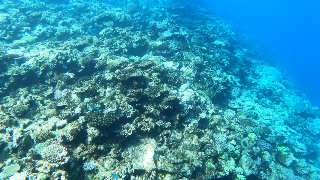

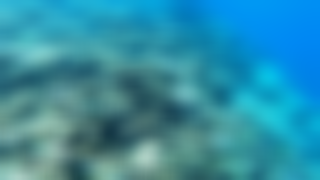

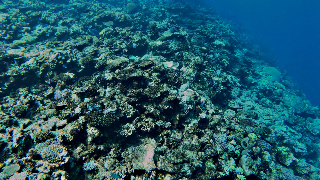

In [108]:
import cv2
from google.colab.patches import cv2_imshow
import random
random.seed(31415)


df = df_train[df_train['annotations'] != '[]']
df = df.reset_index()
for idx, row in df.iterrows():
  print(row['annotations'])
  frame = cv2.imread(f"/content/train_images/video_{row['video_id']}/{row['video_frame']}.jpg")
  balanced = balance_ambient(frame)

  cv2_imshow(cv2.resize(frame,(320,180)))
  cv2_imshow(cv2.resize(ambient,(320,180)))
  cv2_imshow(cv2.resize(balanced,(320,180)))

  break
